In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import cv2
import os 
from os import listdir
from os.path import isfile, join
from PIL import Image

In [2]:
def maintain_aspect_ratio_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Grab the image size and initialize dimensions
    dim = None
    (h, w) = image.shape
    
    # Return original image if no need to resize
    if width is None and height is None:
        return image

    # We are resizing height if width is none
    if width is None:
        # Calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # We are resizing width if height is none
    else:
        # Calculate the ratio of the width and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # Return the resized image
    return cv2.resize(image, dim, interpolation=inter)

<ipython-input-8-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-8-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


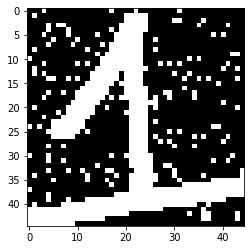

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def noisy(noise_typ,image):   
    if noise_typ == "gauss":
       row,col= image.shape
       mean = 0
       var = 0.1
       sigma = var**0.5
       gauss = np.random.normal(mean,sigma,(row,col))
       gauss = gauss.reshape(row,col)
       noisy = image + gauss
       return noisy
    elif noise_typ == "s&p":
       row,col = image.shape
       s_vs_p = 0.7
       amount = 0.1
       out = np.copy(image)
       # Salt mode
       num_salt = np.ceil(amount * image.size * s_vs_p)
       coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
       out[coords] = 1

      # Pepper mode
       num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
       coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
       out[coords] = 0
       return out
    elif noise_typ == "poisson":
       vals = len(np.unique(image))
       vals = 2 ** np.ceil(np.log2(vals))
       noisy = np.random.poisson(image * vals) / float(vals)
       return noisy
    elif noise_typ =="speckle":
       row,col = image.shape
       gauss = np.random.randn(row,col)
       gauss = gauss.reshape(row,col)        
       noisy = image + image * gauss
       return noisy


#plt.imshow(img, cmap="gray") 
#plt.show()


def black_dilate(img):
    img = ~ img # invert image colours
    #img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_CONSTANT,value=[0, 0, 0])
    kernel = np.ones((2,2), np.uint8)
    img = cv2.dilate(img, kernel, iterations=3)
    return img
    

def poison(img): 
    
    img = ~ img # invert image colours
    img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_CONSTANT,value=[0, 0, 0])
    kernel = np.ones((2,2), np.uint8)
    img = cv2.dilate(img, kernel, iterations=3)    
    img = ~ img
    #plt.imshow(img, cmap="gray") 
    #plt.show()
    img = noisy("poisson",img)
    _,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    #img = cv2.resize(img,(45,45))
    #_,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    #plt.imshow(img, cmap="gray")  
    #plt.show()
    return img

#img = ~ img


def s_and_p(img):
    img = ~ img # invert image colours
    #img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_CONSTANT,value=[0, 0, 0])
    kernel = np.ones((2,2), np.uint8)
    img = cv2.dilate(img, kernel, iterations=3)    
    img = ~ img
    #img = noisy("poisson",img)
    img = noisy("s&p",img)
    img = ~ img
    _,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

    #img = cv2.resize(img,(45,45))
    #plt.imshow(img, cmap="gray") 
    #plt.show()
    return img


def speckle(img):
    img = ~ img # invert image colours
    img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_CONSTANT,value=[0, 0, 0])
    kernel = np.ones((2,2), np.uint8)
    img = cv2.dilate(img, kernel, iterations=3)    
    img = ~ img
    img = noisy("poisson",img)
    img = noisy("s&p",img)
    img = noisy("speckle",img)
    _,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

    #img = cv2.resize(img,(35,35))
    #plt.imshow(img, cmap="gray") 
    #plt.show()
    return img

#img = cv2.copyMakeBorder(img,15,15,15,15,cv2.BORDER_CONSTANT,value=[0, 0, 0])
#kernel = np.ones((2,2), np.uint8)
#x = random.randint(1,4)
#print(x)
#img = cv2.dilate(img, kernel, iterations=x)    

#plt.imshow(img, cmap="gray") 
#plt.show()

img = cv2.imread('C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/1/1_273.jpg',cv2.IMREAD_GRAYSCALE)
out = s_and_p(img)
plt.imshow(out, cmap="gray") 
plt.show()




In [6]:

def choose(img):    
    x = random.randint(1,2)
    
    if x == 1:
        return black_dilate(img)
    if x == 2:
        return s_and_p(img)
    if x == 3:
        return speckle(img)
        
    if x == 4:
        return poison(img)
        

In [21]:
# iterate through each folder to extract images
import random

def load_images_from_folder(folder):
    train_data = []
    # iterate through all images 
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE) # grayscale images used because of contours
        #img = ~ img # invert image colours
        #img = cv2.copyMakeBorder(img,15,15,15,15,cv2.BORDER_CONSTANT,value=[0, 0, 0])
        #kernel = np.ones((2,2), np.uint8)
        #x = random.randint(2,4)
        #img = cv2.dilate(img, kernel, iterations=x)    
        out = choose(img)
        #
        #im_resize = maintain_aspect_ratio_resize(out, width=int(28))
        im_resize = cv2.resize(out,(45,45))
        #im_resize = np.reshape(im_resize,(2025,1))
        #train_data.append(im_resize)

    return im_resize
                    
                    
                       

In [26]:
data = []
x = 0
data = load_images_from_folder('C:/Users/nizen/conda-envs/Final year project/Data/archive1/data/extracted_images/0')

img = data[5]
path = 'C:/Users/nizen/conda-envs/Final year project/Data/Data new/0'
cv2.imwrite(os.path.join(path , '25'+str(0)+'.jpg'), img)
cv2.waitKey(0)

#for i in range(0,len(data)):
    #img = cv2.imread('1.jpg', 1)
    #img = choose(data[i])
#    img = data[i]


<ipython-input-8-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-8-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


-1

In [11]:
# assign '0' = 0
# copy path containing -
data = []
data = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/0")

# upload 70% of the data
data = data[:round(0.9*len(data))]
for i in range(0,len(data)):
    datax =data[i]
    data[i] = np.append(datax,["0"])
# concantinate data
#
#print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


In [12]:
print(len(data))
print(0.9*len(data))
print(round(0.7*len(data)))

6223
5600.7
4356


In [13]:
# assign '1' = 1
# copy path containing -
data1 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/1")
print(len(data1))
# upload 70% of the data
data1 = data1[:round(0.9*len(data1))]
for i in range(0,len(data1)):
    datax = data1[i]
    data1[i] = np.append(datax,["1"])
# concantinate data
print(len(data1))
data = np.concatenate((data,data1))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


26520
23868
30091


In [14]:
# assign '2' = 2
# copy path containing -
data2 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/2")

data2 = data2[:round(0.9*len(data2))]
for i in range(0,len(data2)):
    datax = data2[i]
    data2[i] = np.append(datax,["2"])
# concantinate data
data = np.concatenate((data,data2))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


53618


In [15]:
# assign '3' = 3
# copy path containing -
data3 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/3")

data3 = data3[:round(0.9*len(data3))]
for i in range(0,len(data3)):
    datax = data3[i]
    data3[i] = np.append(datax,["3"])
# concantinate data
data = np.concatenate((data,data3))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


63436


In [16]:
# assign '4' = 4
# copy path containing -
data4 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/4")

data4 = data4[:round(0.9*len(data4))]
for i in range(0,len(data4)):
    datax = data4[i]
    data4[i] = np.append(datax,["4"])
# concantinate data
data = np.concatenate((data,data4))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


70092


In [17]:
# assign '5' = 5
# copy path containing -
data5 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/5")

data5 = data5[:round(0.9*len(data5))]
for i in range(0,len(data5)):
    datax = data5[i]
    data5[i] = np.append(datax,["5"])
# concantinate data
data = np.concatenate((data,data5))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


73282


In [18]:
# assign '6' = 6
# copy path containing -
data6 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/6")

data6 = data6[:round(0.9*len(data6))]
for i in range(0,len(data6)):
    datax = data6[i]
    data6[i] = np.append(datax,["6"])
# concantinate data
data = np.concatenate((data,data6))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


76088


In [19]:
# assign '7' = 7
# copy path containing -
data7 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/7")

data7 = data7[:round(0.9*len(data7))]
for i in range(0,len(data7)):
    datax = data7[i]
    data7[i] = np.append(datax,["7"])
# concantinate data
data = np.concatenate((data,data7))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


78706


In [20]:
# assign '8' = 8
# copy path containing -
data8 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/8")

data8 = data8[:round(0.9*len(data8))]
for i in range(0,len(data8)):
    datax = data8[i]
    data8[i] = np.append(datax,["8"])
# concantinate data
data = np.concatenate((data,data8))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


81467


In [21]:
# assign '9' = 9
# copy path containing -
data9 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/9")

data9 = data9[:round(0.9*len(data9))]
for i in range(0,len(data9)):
    datax = data9[i]
    data9[i] = np.append(datax,["9"])
# concantinate data
data = np.concatenate((data,data9))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


84830


In [22]:

# assign '-' = 10
# copy path containing -
data10 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/-")

data10 = data10[:round(0.9*len(data10))]
for i in range(0,len(data10)):
    datax = data10[i]
    data10[i] = np.append(datax,["10"])
data = np.concatenate((data,data10))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


115427


In [23]:
# assign '+' = 11
# copy path containing -
data11 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/+")

data11 = data11[:round(0.9*len(data11))]
for i in range(0,len(data11)):
    datax = data11[i]
    data11[i] = np.append(datax,["11"])
# concantinate data
data = np.concatenate((data,data11))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


138028


In [24]:
# assign 'times' = 12
# copy path containing -
data12 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/times")

data12 = data12[:round(0.9*len(data12))]
for i in range(0,len(data12)):
    datax = data12[i]
    data12[i] = np.append(datax,["12"])
# concantinate data
data = np.concatenate((data,data12))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


140954


In [25]:
# assign '(' = 13
# copy path containing -
data13 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/(")

data13 = data13[:round(0.9*len(data13))]
for i in range(0,len(data13)):
    datax = data13[i]
    data13[i] = np.append(datax,["13"])
# concantinate data
data = np.concatenate((data,data13))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


153819


In [26]:
# assign ')' = 14
# copy path containing -
data14 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/)")

data14 = data14[:round(0.9*len(data14))]
for i in range(0,len(data14)):
    datax = data14[i]
    data14[i] = np.append(datax,["14"])
# concantinate data
data = np.concatenate((data,data14))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


166739


In [27]:
# assign 'sqrt' = 15
# copy path containing -
data15 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/sqrt")

data15 = data15[:round(0.9*len(data15))]
for i in range(0,len(data15)):
    datax = data15[i]
    data15[i] = np.append(datax,["15"])
# concantinate data
data = np.concatenate((data,data15))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


174756


In [28]:
# assign 'X' = 16
# copy path containing -
#data16 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/X")

#for i in range(0,len(data16)):
#    datax =~data16[i]
#    datax = cv2.dilate(datax, (1,1), iterations=2)
#    datax=~datax
#    datax = cv2.GaussianBlur(datax, (3, 3), 60)
#    datax=~datax
#    data16[i] = np.append(datax,["16"])
# concantinate data
#data = np.concatenate((data,data16))
#print(len(data))

In [29]:
# assign 'y' = 17
# copy path containing -
data16 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/y")

data16 = data16[:round(0.9*len(data16))]
for i in range(0,len(data16)):
    datax = data16[i]
    data16[i] = np.append(datax,["16"])
# concantinate data
data = np.concatenate((data,data16))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


183162


In [30]:
# assign 'gt' = 18
# copy path containing -
data17 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/gt")

data17 = data17[:round(0.9*len(data17))]
for i in range(0,len(data17)):
    datax = data17[i]
    data17[i] = np.append(datax,["17"])
# concantinate data
data = np.concatenate((data,data17))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


183394


In [31]:
# assign 'ls' = 19
# copy path containing -
data18 = load_images_from_folder("C:/Users/nizen/conda-envs/Final year project/Data/archive/data/extracted_images/lt")

data18 = data18[:round(0.9*len(data18))]
for i in range(0,len(data18)):
    datax = data18[i]
    data18[i] = np.append(datax,["18"])
# concantinate data
data = np.concatenate((data,data18))
print(len(data))

<ipython-input-6-ec10d21723c0>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-6-ec10d21723c0>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


183823


# Store data to csv file

In [32]:
df = pd.DataFrame(data,index = None)
df.to_csv('train_final13.csv',index = False)

<ipython-input-188-e80bc1363958>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-188-e80bc1363958>:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


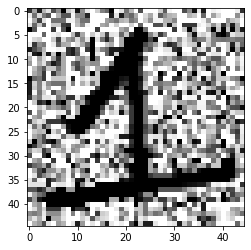

In [190]:
plt.imshow(choose(img), cmap="gray") 
plt.show()

In [191]:
x = random.randint(2,6)
print(x)

5
